In [1]:
pip install dataframe-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 34.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, precision_recall_curve

# Plotly 초기화
py.init_notebook_mode(connected=True)

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold

# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# 데이터 로드
pima_df = pd.read_csv('/content/diabetes.csv')
pima_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
print(pima_df['Glucose'])

0      148
1       85
2      183
3       89
4      137
      ... 
763    101
764    122
765    121
766    126
767     93
Name: Glucose, Length: 768, dtype: int64


In [4]:
# 'Glucose' 열의 최대값
max_glucose = pima_df['Glucose'].max()
print("최대 Glucose 값:", max_glucose)

# 'Glucose' 열의 평균값
mean_glucose = pima_df['Glucose'].mean()
print("평균 Glucose 값:", mean_glucose)

# 'Glucose' 열의 최소값
min_glucose = pima_df['Glucose'].min()
print("최소 Glucose 값:", min_glucose)

최대 Glucose 값: 199
평균 Glucose 값: 120.89453125
최소 Glucose 값: 0


In [5]:
# 구간을 정의합니다.
bins = [i for i in range(0, 220, 20)]

# 구간별 데이터 개수를 계산합니다.
bin_labels = [f"{bins[i]} ~ {bins[i+1]}" for i in range(len(bins)-1)]
pima_df['Glucose Bin'] = pd.cut(pima_df['Glucose'], bins=bins, labels=bin_labels, right=False)
bin_counts = pima_df.groupby('Glucose Bin').size()

# 결과 출력
print(bin_counts)

Glucose Bin
0 ~ 20         5
20 ~ 40        0
40 ~ 60        4
60 ~ 80       32
80 ~ 100     156
100 ~ 120    211
120 ~ 140    163
140 ~ 160     95
160 ~ 180     56
180 ~ 200     46
dtype: int64


In [9]:
import pickle

# 각 질문에 대한 점수를 매기는 함수
def calculate_score(answer, question):
    score = 0
    if answer == '예':
        if question == 0:  # 첫 번째 질문에 대한 점수 설정
            score = 10
        elif question == 1:  # 두 번째 질문에 대한 점수 설정
            score = 10
        elif question == 2:  # 세 번째 질문에 대한 점수 설정
            score = 20
        elif question == 3:  # 네 번째 질문에 대한 점수 설정
            score = 15
        elif question == 4:  # 다섯 번째 질문에 대한 점수 설정
            score = 10
        elif question == 5:  # 여섯 번째 질문에 대한 점수 설정
            score = 10
        elif question == 6:  # 일곱 번째 질문에 대한 점수 설정
            score = 10
        elif question == 7:  # 여덟 번째 질문에 대한 점수 설정
            score = 15
    return score

# 각 항목에 대한 질문과 점수 계산
questions = [
    "평소보다 목이 자주 마르고 더 많이 마시는가? (예: +10 / 아니오: +0)",
    "평소보다 소변을 자주 보러 다니는가? (예: +10 / 아니오: +0)",
    "다리나 팔꿈치, 발, 손에 건조하고 가렵고 갈라지는 피부가 발생하는가? (예: +20 / 아니오: +0)",
    "사물을 볼 때 초점을 맞추기 어려운가? (예: +15 / 아니오: +0)",
    "평소보다 더 자주 피로감을 느끼는가? (예: +10 / 아니오: +0)",
    "과식을 하는가? (예: +10 / 아니오: +0)",
    "체중이 감소하는가? (예: +10 / 아니오: +0)",
    "소변에서 달콤시큼한 냄새가 나는가? (예: +15 / 아니오: +0)"
]

total_score = 0
# 질문과 점수 계산
for i, question in enumerate(questions):
    answer = input(question)
    total_score += calculate_score(answer, i)

print("총 점수:", total_score)

평소보다 목이 자주 마르고 더 많이 마시는가? (예: +10 / 아니오: +0)예
평소보다 소변을 자주 보러 다니는가? (예: +10 / 아니오: +0)ㅇㅖ
다리나 팔꿈치, 발, 손에 건조하고 가렵고 갈라지는 피부가 발생하는가? (예: +20 / 아니오: +0)예
사물을 볼 때 초점을 맞추기 어려운가? (예: +15 / 아니오: +0)아니오
평소보다 더 자주 피로감을 느끼는가? (예: +10 / 아니오: +0)예
과식을 하는가? (예: +10 / 아니오: +0)예
체중이 감소하는가? (예: +10 / 아니오: +0)예
소변에서 달콤시큼한 냄새가 나는가? (예: +15 / 아니오: +0)아니오
총 점수: 60


In [10]:
# Glucose Bin과 점수 범위 설정
glucose_bin = [
    (40, 60), (60, 80), (80, 100),
    (100, 120), (120, 140), (140, 160), (160, 180), (180, 200)
]

score_range = [
    (0, 20), (21, 40), (41, 50), (51, 60), (61, 70), (71, 80), (81, 100)
]

# 각 점수 범위에 대해 Glucose Bin을 매핑
score_to_bin_mapping = {}
for i, score_range in enumerate(score_range):
    score_to_bin_mapping[score_range] = glucose_bin[i]

bin_centers = {
    '0 ~ 20': 0.0,
    '20 ~ 40': 30,
    '40 ~ 60': 53.5,
    '60 ~ 80': 72.97,
    '80 ~ 100': 90.62,
    '100 ~ 120': 118.91,
    '120 ~ 140': 128.43,
    '140 ~ 160': 148.66,
    '160 ~ 180': 168.91,
    '180 ~ 200': 188.39
}

# 각 점수에 대해 Glucose Bin 구간 찾기
def find_glucose_bin(score):
    for score_range, glucose_range in score_to_bin_mapping.items():
        if score_range[0] <= score <= score_range[1]:
            return glucose_range
    return None

# 새로운 환자의 포도당 자가진단 점수에 따라 Glucose Bin 값을 찾는 함수
def assign_glucose_bin(new_patient_glucose_score):
    glucose_bin_range = find_glucose_bin(new_patient_glucose_score)
    if glucose_bin_range:
        bin_label = f"{glucose_bin_range[0]} ~ {glucose_bin_range[1]}"  # Glucose Bin 범위 문자열 생성
        return bin_centers[bin_label]  # 해당 Glucose Bin 범위의 중심값 반환
    else:
        return None  # 유효한 Glucose Bin이 없는 경우 None 반환

# 예시 데이터를 사용하여 포도당 자가진단 점수 계산
glucose_score = total_score

# 해당 점수에 맞는 Glucose Bin 값 할당
glucose_bin_value = assign_glucose_bin(glucose_score)
print("Assigned Glucose Bin Value:", glucose_bin_value)

# 주어진 점수에 대해 Glucose Bin 구간 출력
score = total_score  # 앞서 계산한 총 점수를 사용
glucose_bin_range = find_glucose_bin(score)
print("Total Score:", total_score)
print("Glucose Bin Range:", glucose_bin_range)

Assigned Glucose Bin Value: 118.91
Total Score: 60
Glucose Bin Range: (100, 120)


In [11]:
# pickle을 사용하여 데이터 저장
data_to_save = {
    'score_to_bin_mapping': score_to_bin_mapping,
    'bin_centers': bin_centers
}

with open('glucose_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [12]:
bins = [i for i in range(0, 220, 20)]
bin_labels = [f"{bins[i]} ~ {bins[i+1]}" for i in range(len(bins)-1)]
pima_df['Glucose Bin'] = pd.cut(pima_df['Glucose'], bins=bins, labels=bin_labels, right=False)

bin_centers = {
    '0 ~ 20': 0.0,
    '20 ~ 40': 30,
    '40 ~ 60': 53.5,
    '60 ~ 80': 72.97,
    '80 ~ 100': 90.62,
    '100 ~ 120': 118.91,
    '120 ~ 140': 128.43,
    '140 ~ 160': 148.66,
    '160 ~ 180': 168.91,
    '180 ~ 200': 188.39
}

# Glucose Bin 열을 평균값으로 대체
pima_df['Glucose Bin'] = pima_df['Glucose Bin'].map(bin_centers).astype(float)

# Glucose 열 삭제
pima_df = pima_df.drop(columns=['Glucose'])

# 결과 출력
print(pima_df)

     Pregnancies  BloodPressure  SkinThickness  Insulin   BMI  \
0              6             72             35        0  33.6   
1              1             66             29        0  26.6   
2              8             64              0        0  23.3   
3              1             66             23       94  28.1   
4              0             40             35      168  43.1   
..           ...            ...            ...      ...   ...   
763           10             76             48      180  32.9   
764            2             70             27        0  36.8   
765            5             72             23      112  26.2   
766            1             60              0        0  30.1   
767            1             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  Glucose Bin  
0                       0.627   50        1       148.66  
1                       0.351   31        0        90.62  
2                       0.672   32        

In [13]:
# 데이터 정보 출력
display(pima_df.info(),pima_df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   BloodPressure             768 non-null    int64  
 2   SkinThickness             768 non-null    int64  
 3   Insulin                   768 non-null    int64  
 4   BMI                       768 non-null    float64
 5   DiabetesPedigreeFunction  768 non-null    float64
 6   Age                       768 non-null    int64  
 7   Outcome                   768 non-null    int64  
 8   Glucose Bin               768 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 54.1 KB


None

,Pregnancies,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose Bin
0,6,72,35,0,33.6,0.627,50,1,148.66
1,1,66,29,0,26.6,0.351,31,0,90.62
2,8,64,0,0,23.3,0.672,32,1,188.39
3,1,66,23,94,28.1,0.167,21,0,90.62
4,0,40,35,168,43.1,2.288,33,1,128.43
5,5,74,0,0,25.6,0.201,30,0,118.91
6,3,50,32,88,31.0,0.248,26,1,72.97
7,10,0,0,0,35.3,0.134,29,0,118.91
8,2,70,45,543,30.5,0.158,53,1,188.39
9,8,96,0,0,0.0,0.232,54,1,128.43


In [14]:
# 데이터 요약 통계 출력
pima_df.describe()

,Pregnancies,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose Bin
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958,123.642526
std,3.369578,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951,30.721749
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000,0.000000
25%,1.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000,90.620000
50%,3.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000,118.910000
75%,6.000000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000,148.660000
max,17.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000,188.390000


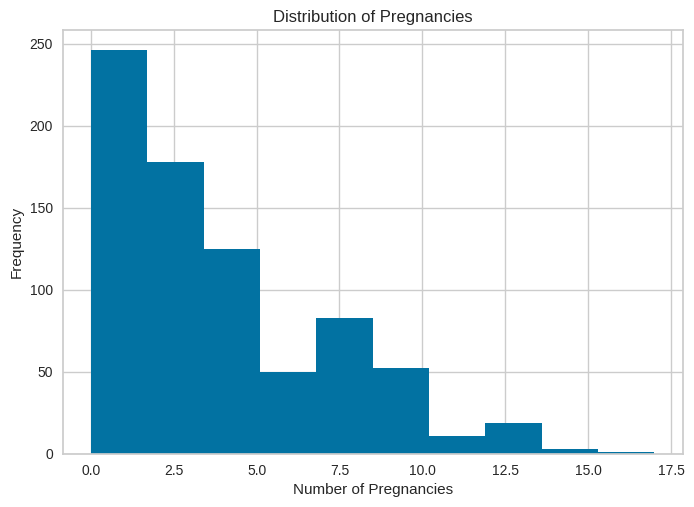

In [15]:
# 각 피처별 분포 시각화 (Pregnancies)
pima_df['Pregnancies'].hist()
plt.title('Distribution of Pregnancies')
plt.xlabel('Number of Pregnancies')
plt.ylabel('Frequency')
plt.show()

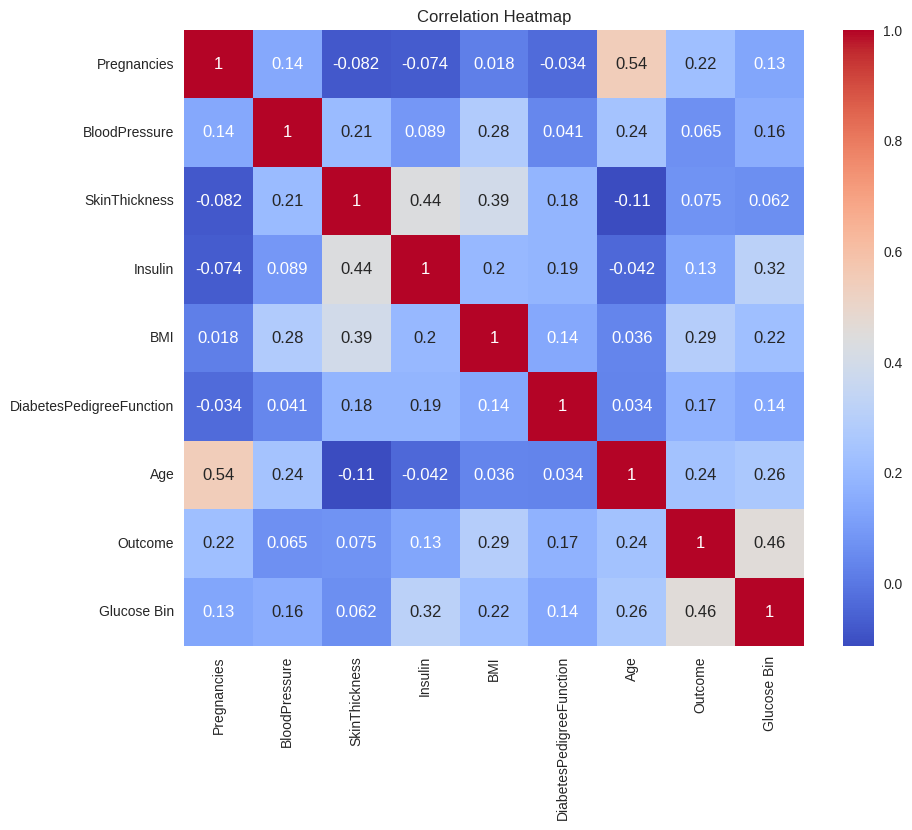

In [16]:
# 피처 간 상관 관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(pima_df.corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [17]:
pima_df.corr(method = 'pearson')

,Pregnancies,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose Bin
Pregnancies,1.000000,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898,0.129884
BloodPressure,0.141282,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068,0.156822
SkinThickness,-0.081672,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752,0.061938
Insulin,-0.073535,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548,0.315940
BMI,0.017683,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695,0.222182
DiabetesPedigreeFunction,-0.033523,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844,0.135425
Age,0.544341,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356,0.263364
Outcome,0.221898,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000,0.458851
Glucose Bin,0.129884,0.156822,0.061938,0.315940,0.222182,0.135425,0.263364,0.458851,1.000000


In [18]:
pima_df.describe()
#precnancies, gucose, bloodpressure, skonthickness,lnsulin
pima_df[pima_df['Pregnancies']==0]['Pregnancies'].count()

zero_mean_column = ['Glucose Bin', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

total_data_count = pima_df['Pregnancies'].count()

for col in zero_mean_column:
    zero_count = pima_df[pima_df[col] == 0][col].count()
    print('{} 전체 데이터 건수 : {}, 0의 비율 : {:.2f}%'.format(col, total_data_count, 100 * zero_count / total_data_count))

Glucose Bin 전체 데이터 건수 : 768, 0의 비율 : 0.65%
BloodPressure 전체 데이터 건수 : 768, 0의 비율 : 4.56%
SkinThickness 전체 데이터 건수 : 768, 0의 비율 : 29.56%
Insulin 전체 데이터 건수 : 768, 0의 비율 : 48.70%
BMI 전체 데이터 건수 : 768, 0의 비율 : 1.43%


In [19]:
# 0 값이 있는 열들을 해당 열의 평균값으로 대체, 데이터 왜곡 줄이기
zero_mean_column_mean = pima_df[zero_mean_column].mean()
pima_df[zero_mean_column] = pima_df[zero_mean_column].replace(0, zero_mean_column_mean)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# 경고 메시지 숨기기
warnings.filterwarnings("ignore", category=FutureWarning)

# 데이터 프레임에서 독립 변수 X와 종속 변수 Y 정의
X = pima_df.drop(columns=['Outcome'])  # 독립 변수(Feature)
Y = pima_df['Outcome']  # 종속 변수(Target)

# 데이터 스케일링 및 Train-Test 분리
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=156, stratify=Y)

# Train-Validation 분리
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

# Logistic Regression 모델 생성 및 학습
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(X_train, Y_train)

# 모델 평가
train_score = Logistic.score(X_train, Y_train)
val_score = Logistic.score(X_val, Y_val)
test_score = Logistic.score(X_test, Y_test)

print("Train Accuracy:", train_score)
print("Validation Accuracy:", val_score)
print("Test Accuracy:", test_score)

# 테스트 데이터에 대한 예측
pred_proba = Logistic.predict_proba(X_test)[:, 1]

Train Accuracy: 0.7891304347826087
Validation Accuracy: 0.7532467532467533
Test Accuracy: 0.7987012987012987


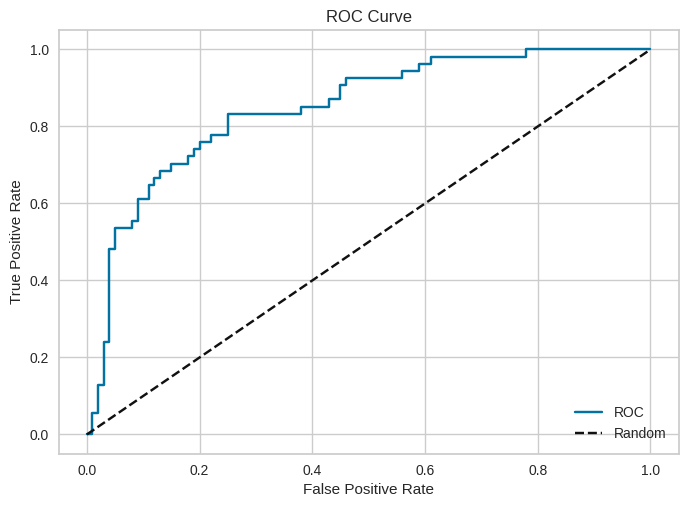

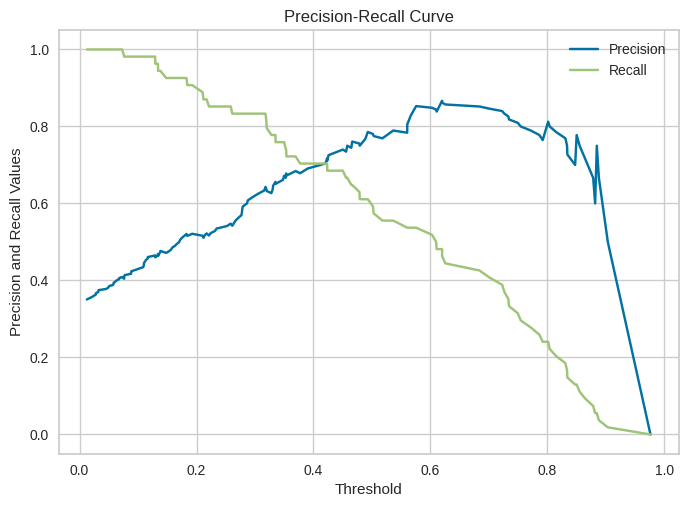

In [21]:
# ROC-AUC curve 출력
fpr, tpr, thresholds = roc_curve(Y_test, pred_proba)
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve 출력
precisions, recalls, thresholds = precision_recall_curve(Y_test, pred_proba)
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [22]:
# Logistic Regression 모델 학습
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [23]:
val_score = Logistic.score(X_val, Y_val)
print("Validation Accuracy:", val_score)

Validation Accuracy: 0.7532467532467533


In [24]:
print(X_val.shape)

(154, 8)


In [25]:
print(X.shape)

(768, 8)


In [27]:
# 새로운 환자의 데이터 입력 (예시 데이터)
new_patient_data = [[4, 80, 20, 94, 33.6, 0.6, 30, 90.62]]  # 새로운 환자의 데이터

# 새로운 환자 데이터를 DataFrame으로 변환 (피처 이름을 지정)
new_patient_df = pd.DataFrame(new_patient_data, columns=X.columns)

# 데이터 스케일링
new_patient_data_scaled = scaler.transform(new_patient_df)

# 환자가 당뇨에 걸릴 확률 예측
probability = Logistic.predict_proba(new_patient_data_scaled)[:, 1]  # 당뇨에 걸릴 확률만 선택

# 기존의 예측 확률에서 임계값을 조절하여 예측을 보다 보수적으로 만듦.
threshold = 0.6  # 새로운 임계값 설정
adjusted_prediction = [1 if prob >= threshold else 0 for prob in probability]

# 조정된 예측 결과를 사용하여 확률을 다시 계산.
adjusted_probability = sum(adjusted_prediction) / len(adjusted_prediction)

# 결과 출력
print("Test Accuracy:", test_score)
print("새로운 환자가 당뇨에 걸릴 확률: {:.2f}%".format(probability[0] * 100))


Test Accuracy: 0.7987012987012987
새로운 환자가 당뇨에 걸릴 확률: 13.62%


In [28]:
import pickle
#save
with open('model_final.pkl','wb')as f:
  pickle.dump(Logistic,f)